In [38]:
import sys
sys.path.append("/home/hoang/WorkSpace/centernet")

from src.datamodules.voc_datamodule import VOCDataModule

In [39]:
dtm = VOCDataModule("../data", year="2007", batch_size=4)
dtm.setup()

Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data
Using downloaded and verified file: ../data/VOCtrainval_06-Nov-2007.tar
Extracting ../data/VOCtrainval_06-Nov-2007.tar to ../data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


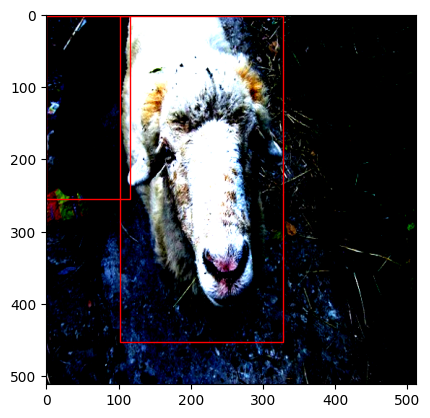

In [40]:
import matplotlib.pyplot as plt
import torch
from typing import Tuple

def plot_data(img: torch.Tensor, bboxes: torch.Tensor):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)
    plt.show()

for batch in dtm.train_dataloader():
    img, bboxes, labels = batch
    plot_data(img[0], bboxes[0])
    break

In [41]:
from src.models.centernet_module import CenterNet
from src.models.components.resnet import PoseResNet, BasicBlock

model = CenterNet(
    PoseResNet(
        BasicBlock,
        18,
        [2, 2, 2, 2],
        num_classes=21,
    ),
    optimizer=torch.optim.Adam,
    scheduler=torch.optim.lr_scheduler.StepLR,
)

In [42]:
keypoints, offsets, sizes = model._get_object_params(bboxes, downsample=.25)

In [43]:
keypoints

[tensor([[14, 32],
         [53, 56]], dtype=torch.int32),
 tensor([[101,  90],
         [ 67,  79]], dtype=torch.int32),
 tensor([[77, 66]], dtype=torch.int32),
 tensor([[19, 72],
         [45, 73],
         [32, 65]], dtype=torch.int32)]

In [44]:
heatmaps = model._produce_gt_heatmap(keypoints, labels, model.num_classes, 128, 128)

In [45]:
heatmaps[0].shape

torch.Size([21, 128, 128])

In [46]:
offsets_map, sizes_map, masks = model._produce_gt_offset_and_size(keypoints, offsets, sizes, 128, 128)

In [47]:
from src.utils import decode

dec_bboxes, scores, classes = decode(heatmaps, offsets_map, sizes_map, .25, top_k=100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


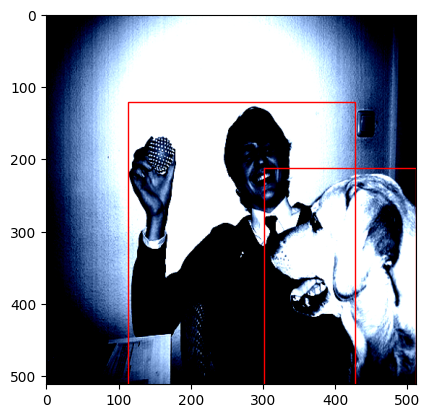

In [49]:
plot_data(img[1], dec_bboxes[1])